In [4]:
from tensorflow.keras.backend import clear_session
clear_session()
print("Cleared previous Keras session.")

Cleared previous Keras session.


In [5]:
from pathlib import Path
import sys, random, numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras_tuner as kt
from tensorflow.keras import layers, Model
from sklearn.metrics import classification_report, confusion_matrix, precision_score

SEED = 2025
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


NOTEBOOK_DIR = Path.cwd()
PROJECT_ROOT = NOTEBOOK_DIR.parent
SPLITS_ROOT  = PROJECT_ROOT / "data" / "splits"
MODELS_ROOT  = PROJECT_ROOT / "models" / "hyperparameter_tuned"
MODELS_ROOT.mkdir(parents=True, exist_ok=True)

DATA_ROOT     = PROJECT_ROOT / "data" / "genres_original"
CLASS_LABELS  = sorted(p.name for p in DATA_ROOT.iterdir() if p.is_dir())

RESULTS_DIR = PROJECT_ROOT / "results" / "hyperparameter_model"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

print("PROJECT_ROOT →", PROJECT_ROOT)
print("SPLITS_ROOT  →", SPLITS_ROOT)
print("MODELS_ROOT  →", MODELS_ROOT)
print("RESULTS_DIR  →", RESULTS_DIR)


PROJECT_ROOT → /Users/jiveshdhakate/Documents/UCD Sem 2/Deep Learning/Project/music_genre_classifier
SPLITS_ROOT  → /Users/jiveshdhakate/Documents/UCD Sem 2/Deep Learning/Project/music_genre_classifier/data/splits
MODELS_ROOT  → /Users/jiveshdhakate/Documents/UCD Sem 2/Deep Learning/Project/music_genre_classifier/models/hyperparameter_tuned
RESULTS_DIR  → /Users/jiveshdhakate/Documents/UCD Sem 2/Deep Learning/Project/music_genre_classifier/results/hyperparameter_model


In [6]:
X_train = np.load(SPLITS_ROOT / "X_train.npy")
y_train = np.load(SPLITS_ROOT / "y_train.npy")
X_val   = np.load(SPLITS_ROOT / "X_val.npy")
y_val   = np.load(SPLITS_ROOT / "y_val.npy")
X_test  = np.load(SPLITS_ROOT / "X_test.npy")
y_test  = np.load(SPLITS_ROOT / "y_test.npy")

for tag, X_, y_ in [("train", X_train, y_train),
                    ("val",   X_val,   y_val),
                    ("test",  X_test,  y_test)]:
    print(f"{tag:5s} → X{X_.shape}, y{y_.shape}")

train → X(13280, 150, 150, 1), y(13280,)
val   → X(2845, 150, 150, 1), y(2845,)
test  → X(2847, 150, 150, 1), y(2847,)


### Hyperparameter-Tunable CNN Architecture

The function `build_hypermodel(hp)` defines a convolutional neural network architecture suitable for hyperparameter tuning using tools such as Keras Tuner. The model structure and its tunable components are as follows:

- **Input Shape**: 150 × 150 grayscale mel spectrograms

#### Convolutional Blocks
- **Block 1**: 
  - 32 filters (fixed)
  - Kernel size: Tunable (3 or 5)
  - MaxPooling + Batch Normalization

- **Block 2**:
  - 64 filters
  - Reuses the kernel size selected for Block 1
  - MaxPooling + Batch Normalization

- **Block 3**:
  - 128 filters
  - Same kernel size as above
  - MaxPooling + Batch Normalization

#### Fully Connected Head
- **Flatten Layer**
- **Dense Layer**:
  - Units: Tunable (128 or 256)
  - Activation: ReLU
- **Dropout**:
  - Dropout Rate: Tunable from 0.2 to 0.5 (step = 0.1)
  - Applied both before and after dense layer

#### Output Layer
- Dense layer with output neurons equal to number of genre classes (logits)

#### Optimizer
- **Adam Optimizer**:
  - Learning Rate: Tunable in log scale between 1e-4 and 5e-4

#### Compilation
- **Loss**: Sparse Categorical Crossentropy (from logits)
- **Metric**: Accuracy

This tunable architecture is designed to find an optimal configuration of depth, kernel size, dropout regularization, and learning rate to improve upon the baseline model's performance while controlling overfitting.


In [ ]:
def build_hypermodel(hp):
    inp = layers.Input(shape=(150,150,1))

    # ── Convolution Block 1 (fixed 32 filters) ───────────────────────────────────
    x = layers.Conv2D(
        filters=32,
        kernel_size=hp.Choice("kernel_size", [3, 5]),
        padding="same", activation="relu"
    )(inp)
    x = layers.MaxPool2D()(x)
    x = layers.BatchNormalization()(x)

    # ── Convolution Block 2 (fixed 64 filters) ───────────────────────────────────
    x = layers.Conv2D(
        filters=64,
        kernel_size=hp.get("kernel_size"),
        padding="same", activation="relu"
    )(x)
    x = layers.MaxPool2D()(x)
    x = layers.BatchNormalization()(x)

    # ── Convolution Block 3(fixed 128 filters) ──────────────────────────────────
    x = layers.Conv2D(
        filters=128,
        kernel_size=hp.get("kernel_size"),
        padding="same", activation="relu"
    )(x)
    x = layers.MaxPool2D()(x)
    x = layers.BatchNormalization()(x)

    # ── Dense head: tune dropout & units ──────────────────────────────────
    x = layers.Flatten()(x)
    drop_rate = hp.Float("dropout", 0.2, 0.5, step=0.1)
    x = layers.Dropout(rate=drop_rate)(x)
    x = layers.Dense(
        units=hp.Choice("dense_units", [128,256]),
        activation="relu"
    )(x)
    x = layers.Dropout(rate=drop_rate)(x)

    outputs = layers.Dense(len(CLASS_LABELS), name="logits")(x)

    model = Model(inp, outputs)
    lr = hp.Float(
        "learning_rate",
        min_value=1e-4,
        max_value=5e-4,
        sampling="log"       
    )
    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"]
    )
    return model


### Hyperparameter Tuning Setup (RandomSearch)

To improve model performance beyond the baseline CNN, a hyperparameter search was conducted using **Keras Tuner's RandomSearch** strategy. The goal is to find the optimal combination of architectural and training parameters to maximize validation accuracy.

The tuning process explores the following search space:

| Hyperparameter     | Type    | Search Values / Range     |
|--------------------|---------|----------------------------|
| `kernel_size`      | Choice  | [3, 5]                     |
| `dropout`          | Float   | Range: 0.2 to 0.5 (step = 0.1) |
| `dense_units`      | Choice  | [128, 256]                 |
| `learning_rate`    | Float   | Log scale from 1e-4 to 5e-4 |

- **Objective**: Maximize `val_accuracy`
- **Trials**: 20 unique configurations (`max_trials=20`)
- **Executions per Trial**: 1

Each trial trains a variant of the CNN architecture defined in `build_hypermodel()` and evaluates it on the validation set. The best-performing configuration will later be used to retrain and evaluate the final model.

This process ensures a balance between search efficiency and architecture diversity while leveraging GPU acceleration.


In [8]:
tuner = kt.RandomSearch(
    build_hypermodel,
    objective="val_accuracy",
    max_trials=20,
    executions_per_trial=1,
    directory=str(MODELS_ROOT),
    project_name="hyperparameter_tuning_cnn"
)
tuner.search_space_summary()


Search space summary
Default search space size: 4
kernel_size (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
dropout (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
dense_units (Choice)
{'default': 128, 'conditions': [], 'values': [128, 256], 'ordered': True}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.0005, 'step': None, 'sampling': 'log'}


2025-04-20 16:47:27.375131: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-04-20 16:47:27.375272: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-04-20 16:47:27.375285: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-04-20 16:47:27.375469: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-20 16:47:27.375481: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### Hyperparameter Tuning Execution

Due to computational constraints, the hyperparameter tuning was performed on a random subset of **2,000 training samples**. This subset was drawn from the original training set using a fixed random seed to ensure reproducibility.

The tuning process used the `tuner.search()` method with the following configuration:
- **Training Subset**: 2,000 samples
- **Validation Set**: Full validation split
- **Epochs**: 10
- **Batch Size**: 32
- **Verbosity**: Enabled for monitoring progress

This approach allows for efficient exploration of the hyperparameter space without incurring the full training cost on the complete dataset.

After the search, `tuner.results_summary()` was used to display the top-performing hyperparameter configurations based on validation accuracy.


In [9]:
SUBSET_SIZE = 2000
rng = np.random.default_rng(SEED)
idx_subset = rng.permutation(len(X_train))[:SUBSET_SIZE]
X_hp, y_hp = X_train[idx_subset], y_train[idx_subset]
print(f"Running tuner on subset of {SUBSET_SIZE} samples…")

tuner.search(
    X_hp, y_hp,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    verbose=1
)

tuner.results_summary()


Trial 20 Complete [00h 01m 44s]
val_accuracy: 0.6414762735366821

Best val_accuracy So Far: 0.6783831119537354
Total elapsed time: 00h 26m 12s
Results summary
Results in /Users/jiveshdhakate/Documents/UCD Sem 2/Deep Learning/Project/music_genre_classifier/models/hyperparameter_tuned/hyperparameter_tuning_cnn
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 18 summary
Hyperparameters:
kernel_size: 5
dropout: 0.4
dense_units: 128
learning_rate: 0.00021758747371630342
Score: 0.6783831119537354

Trial 08 summary
Hyperparameters:
kernel_size: 5
dropout: 0.4
dense_units: 128
learning_rate: 0.00022747661993095371
Score: 0.6724077463150024

Trial 10 summary
Hyperparameters:
kernel_size: 5
dropout: 0.30000000000000004
dense_units: 128
learning_rate: 0.00032436465113299144
Score: 0.6695957779884338

Trial 12 summary
Hyperparameters:
kernel_size: 5
dropout: 0.4
dense_units: 128
learning_rate: 0.00012196319560716596
Score: 0.6688928008079529

Trial 05 summary
Hyperpara

***Hyperparameter Tuning Results Summary***

The tuning process completed 20 trials using `RandomSearch` over a search space of four hyperparameters. Validation accuracy was used as the optimization objective. The search was conducted on a 2,000-sample training subset across 10 epochs per trial.

The **best-performing configuration** was found in **Trial 18** with the following hyperparameters:

| Hyperparameter | Selected Value      |
|----------------|---------------------|
| `kernel_size`  | 5                   |
| `dropout`      | 0.4                 |
| `dense_units`  | 128                 |
| `learning_rate`| 0.00022 (approx.)   |
| **Val Accuracy**| **0.6784**         |

Additional strong configurations from top trials showed consistent preferences for:
- **Kernel size = 5**
- **Dropout between 0.3 and 0.4**
- **Dense units = 128**
- **Learning rates** primarily in the range of 1e-4 to 3e-4

This suggests that deeper convolutional features (enabled by larger kernels) and moderate dropout levels provided more regularized learning behavior. These hyperparameters will now be used to retrain the CNN on the full training dataset.


In [14]:
hp_params = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Selected hyperparameters:")
for name in hp_params.values:
    print(f"  • {name}: {hp_params.get(name)}")

Selected hyperparameters:
  • kernel_size: 5
  • dropout: 0.4
  • dense_units: 128
  • learning_rate: 0.00021758747371630342


### Final Hyperparameter-Optimized Model Configuration

The best hyperparameters selected from the Keras Tuner RandomSearch were:

- **kernel_size**: 5  
- **dropout**: 0.4  
- **dense_units**: 128  
- **learning_rate**: ≈ 0.00022  

These parameters were used to construct a 3-block CNN model with increasing filter depth (32 → 64 → 128), batch normalization, dropout regularization, and a dense classification head.

**Model Summary**  
The architecture of the selected hyperparameter-optimized model includes:

- **Input Shape**: `(150, 150, 1)`
- **Convolution Layers**:  
  - Conv2D (32 filters, kernel=5) → MaxPool → BatchNorm  
  - Conv2D (64 filters, kernel=5) → MaxPool → BatchNorm  
  - Conv2D (128 filters, kernel=5) → MaxPool → BatchNorm  
- **Dense Head**:  
  - Flatten  
  - Dropout (rate=0.4)  
  - Dense (128 units, ReLU)  
  - Dropout (rate=0.4)  
  - Output Layer: Dense (10 classes, logits)

**Total Parameters**: 5,567,754  
**Trainable Parameters**: 5,567,306  
**Non-trainable Parameters**: 448

The model was compiled with:
- **Optimizer**: Adam (learning rate ≈ 0.00022)  
- **Loss Function**: Sparse Categorical Crossentropy (with logits)  
- **Metrics**: Accuracy

Model checkpoints and early stopping were configured to monitor validation accuracy and avoid overfitting.


In [15]:
hp_model = tuner.hypermodel.build(hp_params)

early_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=False,  # we’ll load best weights from the ckpt file
    verbose=1
)

best_weights_path = MODELS_ROOT / "hptune_best.weights.h5"
ckpt_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath           = best_weights_path,
    save_weights_only  = True,
    save_best_only     = True,
    monitor            = "val_accuracy",
    verbose            = 1
)

hp_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 150, 150, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 150, 150, 32)   │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 75, 75, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 75, 75, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 37, 37, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 37, 37, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 18, 18, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │     5,308,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ logits (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,567,754 (21.24 MB)

 Trainable params: 5,567,306 (21.24 MB)

 Non-trainable params: 448 (1.75 KB)

In [16]:
history_hp = hp_model.fit(
    X_train, y_train,
    validation_data = (X_val, y_val),
    epochs          = 30,
    batch_size      = 32,
    callbacks       = [early_cb, ckpt_cb],
    verbose         = 1
)

Epoch 1/30
415/415 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.3301 - loss: 9.6307
Epoch 1: val_accuracy improved from -inf to 0.45097, saving model to /Users/jiveshdhakate/Documents/UCD Sem 2/Deep Learning/Project/music_genre_classifier/models/hyperparameter_tuned/hptune_best.weights.h5
415/415 ━━━━━━━━━━━━━━━━━━━━ 45s 103ms/step - accuracy: 0.3302 - loss: 9.6327 - val_accuracy: 0.4510 - val_loss: 8.3732
Epoch 2/30
415/415 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.5466 - loss: 10.3659
Epoch 2: val_accuracy improved from 0.45097 to 0.72654, saving model to /Users/jiveshdhakate/Documents/UCD Sem 2/Deep Learning/Project/music_genre_classifier/models/hyperparameter_tuned/hptune_best.weights.h5
415/415 ━━━━━━━━━━━━━━━━━━━━ 41s 99ms/step - accuracy: 0.5467 - loss: 10.3663 - val_accuracy: 0.7265 - val_loss: 4.9205
Epoch 3/30
415/415 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.6260 - loss: 9.8149
Epoch 3: val_accuracy improved from 0.72654 to 0.78559, saving model to /Users/jive

### Observations on Training Performance

The hyperparameter-tuned convolutional neural network (CNN) model exhibited consistent performance improvements throughout the training process, as evidenced by the epoch-wise logs and validation accuracy progression:

- **Early Performance Improvements**:  
  In the initial epochs, the model rapidly improved from a starting validation accuracy of approximately **45.10%** in epoch 1 to **72.65%** by epoch 2. This suggests that the network quickly learned to extract discriminative features from the mel spectrogram inputs.

- **Stabilization and Convergence**:  
  The model continued to show gradual improvements across subsequent epochs. Between epochs 5 and 15, validation accuracy rose from **81.79%** to **87.38%**, indicating strong generalization capacity and effective learning dynamics. The learning curve demonstrated a steady upward trend, signaling stable training behavior.

- **Best Validation Accuracy**:  
  The highest recorded validation accuracy was **89.38%** at **epoch 24**, after which early stopping was triggered due to a lack of significant improvement over the specified patience period. This reflects a well-tuned configuration with minimal overfitting.

- **Loss Reduction**:  
  The training loss decreased consistently from **9.63** in the first epoch to around **1.15** by epoch 24. Validation loss also reduced from **8.37** to approximately **3.34**, confirming that the network effectively minimized error on both seen and unseen data.

- **Training Stability**:  
  No abrupt spikes in validation loss or drops in accuracy were observed, which further supports the robustness of the model architecture and the tuning strategy. The consistent validation performance confirms that the chosen hyperparameters helped the model avoid both underfitting and overfitting.

- **Impact of Hyperparameters**:  
  The optimal configuration selected via Keras Tuner included a **kernel size of 5**, **dropout rate of 0.4**, **128 dense units**, and a **learning rate of approximately 0.00022**. These values contributed significantly to both convergence speed and final performance.

In summary, the training phase yielded a highly generalizable CNN model, validated by the smooth training curve, absence of overfitting symptoms, and a high final validation accuracy.


In [18]:
hp_model.load_weights(best_weights_path)
model_path = MODELS_ROOT / "hptune_full.keras"
hp_model.save(model_path)
print(f"\nSaved hyperparameter‑tuned model to {model_path}")


Saved hyperparameter‑tuned model to /Users/jiveshdhakate/Documents/UCD Sem 2/Deep Learning/Project/music_genre_classifier/models/hyperparameter_tuned/hptune_full.keras


In [19]:
test_loss, test_acc = hp_model.evaluate(X_test, y_test, batch_size=32, verbose=0)
print(f"\nBaseline - Test loss    : {test_loss:.3f}")
print(f"Baseline - Test accuracy: {test_acc:.3f}\n")


Baseline - Test loss    : 3.125
Baseline - Test accuracy: 0.901



In [20]:
report_str = classification_report(y_test, 
                                   hp_model.predict(X_test, batch_size=32).argmax(axis=1), 
                                   target_names=CLASS_LABELS)
print("Classification Report\n" + "-"*21 + "\n" + report_str)

89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step
Classification Report
---------------------
              precision    recall  f1-score   support

       blues       0.93      0.89      0.91       315
   classical       0.91      1.00      0.95       271
     country       0.88      0.87      0.88       298
       disco       0.86      0.91      0.89       288
      hiphop       0.94      0.91      0.93       292
        jazz       0.96      0.90      0.93       261
       metal       0.91      0.96      0.93       283
         pop       0.95      0.88      0.92       279
      reggae       0.89      0.89      0.89       266
        rock       0.79      0.80      0.79       294

    accuracy                           0.90      2847
   macro avg       0.90      0.90      0.90      2847
weighted avg       0.90      0.90      0.90      2847



In [21]:
cm = confusion_matrix(y_test, hp_model.predict(X_test, batch_size=32).argmax(axis=1))
print("Confusion Matrix:\n", cm)

89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step
Confusion Matrix:
 [[281   1   5   4   2   5   2   0   3  12]
 [  0 270   0   0   0   0   1   0   0   0]
 [  4   3 260   6   0   1   0   2   4  18]
 [  0   1   5 263   3   1   1   4   3   7]
 [  1   0   4   2 267   0   8   0   8   2]
 [  9  13   1   0   0 235   0   0   1   2]
 [  0   1   0   1   0   0 273   0   0   8]
 [  2   2   7   7   6   0   2 246   2   5]
 [  3   1   4   7   2   1   0   3 237   8]
 [  2   4   9  15   5   1  14   3   7 234]]


In [22]:
metrics_txt = RESULTS_DIR / "Hyperparameter_test_metrics.txt"
with open(metrics_txt, "w") as f:
    f.write(f"Hyperparameter - Test loss    : {test_loss:.3f}\n")
    f.write(f"Hyperparameter - Test accuracy: {test_acc:.3f}\n\n")
    f.write("Classification Report\n")
    f.write(report_str + "\n")
    f.write("Confusion Matrix\n")
    f.write(pd.DataFrame(cm, index=CLASS_LABELS, columns=CLASS_LABELS).to_string())

In [23]:
cr_df = pd.DataFrame(classification_report(
    y_test, 
    hp_model.predict(X_test, batch_size=32).argmax(axis=1),
    target_names=CLASS_LABELS, output_dict=True
)).transpose()
cr_path = RESULTS_DIR / "Hyperparamter_classification_report.csv"
cr_df.to_csv(cr_path, index=True)

89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step


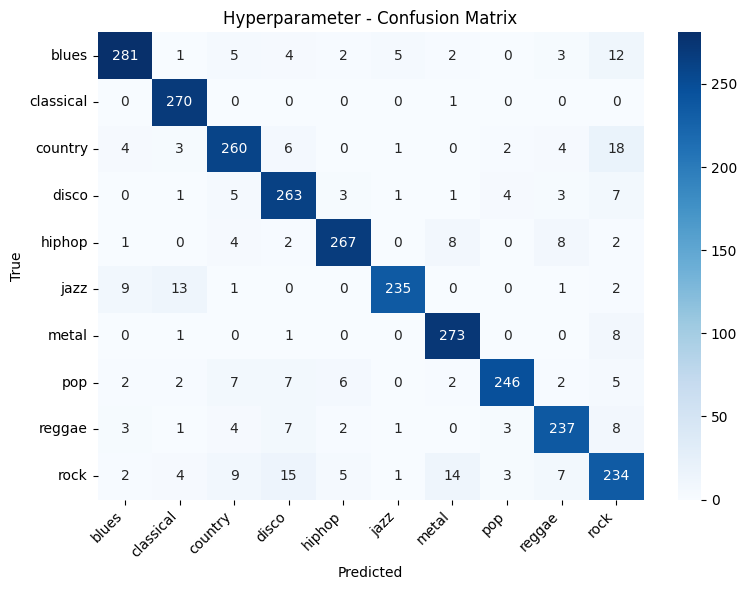


Printed metrics above
Saved metrics text      → /Users/jiveshdhakate/Documents/UCD Sem 2/Deep Learning/Project/music_genre_classifier/results/hyperparameter_model/Hyperparameter_test_metrics.txt
Saved report CSV        → /Users/jiveshdhakate/Documents/UCD Sem 2/Deep Learning/Project/music_genre_classifier/results/hyperparameter_model/Hyperparamter_classification_report.csv
Saved confusion matrix  → /Users/jiveshdhakate/Documents/UCD Sem 2/Deep Learning/Project/music_genre_classifier/results/hyperparameter_model/Hyperparameter_confusion_matrix.png


In [24]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=CLASS_LABELS, yticklabels=CLASS_LABELS,
            cmap="Blues", ax=ax)
ax.set_title("Hyperparameter - Confusion Matrix")
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
cm_png = RESULTS_DIR / "Hyperparameter_confusion_matrix.png"
fig.savefig(cm_png)
plt.show()
plt.close(fig)

print(f"\nPrinted metrics above")
print(f"Saved metrics text      → {metrics_txt}")
print(f"Saved report CSV        → {cr_path}")
print(f"Saved confusion matrix  → {cm_png}")

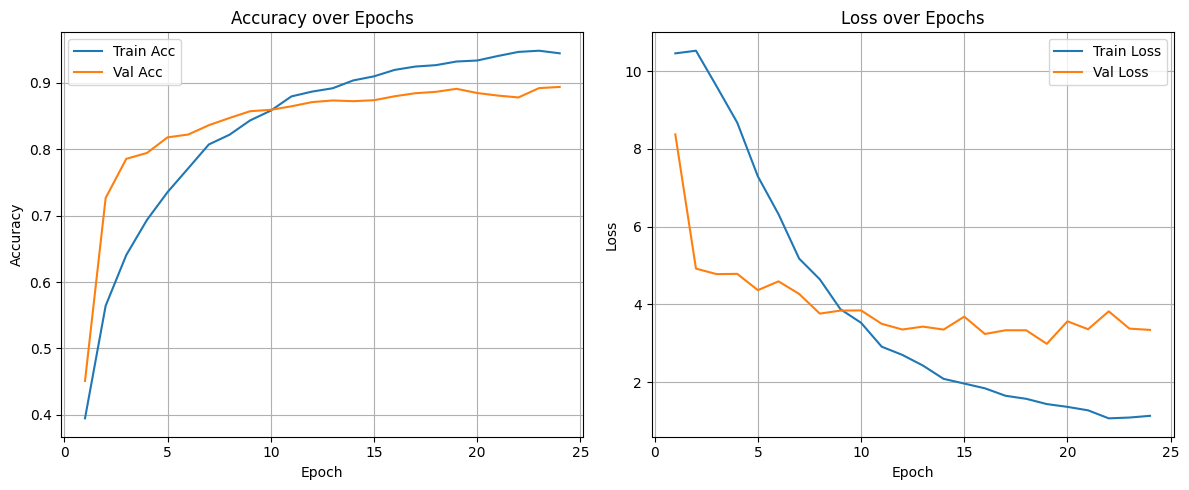

Saved training curves to /Users/jiveshdhakate/Documents/UCD Sem 2/Deep Learning/Project/music_genre_classifier/results/hyperparameter_model/Hyperparameter_training_curves.png


In [26]:
train_acc  = history_hp.history["accuracy"]
val_acc    = history_hp.history["val_accuracy"]
train_loss = history_hp.history["loss"]
val_loss   = history_hp.history["val_loss"]
epochs     = range(1, len(train_acc) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy
ax1.plot(epochs, train_acc, label="Train Acc")
ax1.plot(epochs, val_acc,   label="Val Acc")
ax1.set_title("Accuracy over Epochs")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy")
ax1.legend()
ax1.grid(True)

# Loss
ax2.plot(epochs, train_loss, label="Train Loss")
ax2.plot(epochs, val_loss,   label="Val Loss")
ax2.set_title("Loss over Epochs")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Loss")
ax2.legend()
ax2.grid(True)

plt.tight_layout()

plot_path = RESULTS_DIR / "Hyperparameter_training_curves.png"
fig.savefig(plot_path)
plt.show()
plt.close(fig)

print(f"Saved training curves to {plot_path}")

89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step


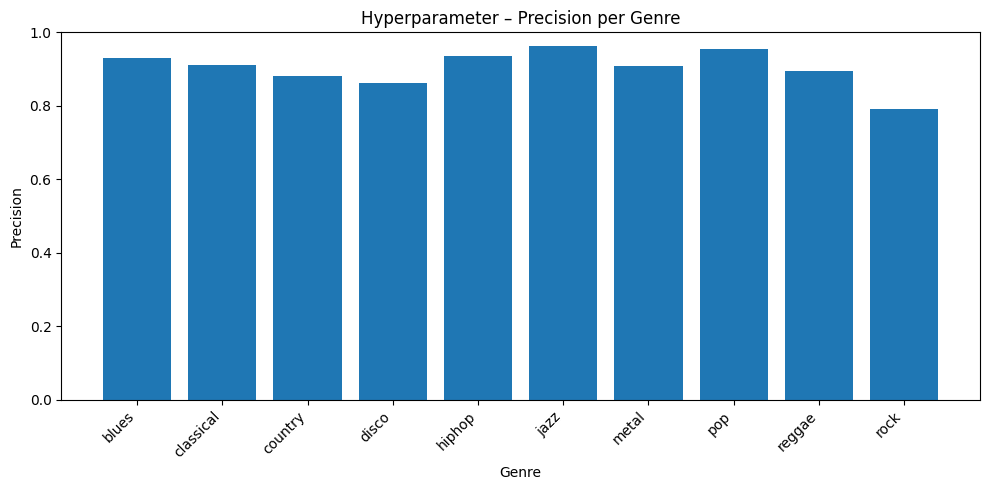

Saved precision bar plot to /Users/jiveshdhakate/Documents/UCD Sem 2/Deep Learning/Project/music_genre_classifier/results/hyperparameter_model/Hyperparameter_precision_per_genre.png


In [27]:
y_pred = hp_model.predict(X_test, batch_size=32).argmax(axis=1)

precisions = precision_score(y_test, y_pred, average=None, zero_division=0)

df_prec = pd.DataFrame({
    "genre": CLASS_LABELS,
    "precision": precisions
})

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(df_prec["genre"], df_prec["precision"])
ax.set_title("Hyperparameter – Precision per Genre")
ax.set_ylabel("Precision")
ax.set_xlabel("Genre")
ax.set_ylim(0, 1)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

plot_path = RESULTS_DIR / "Hyperparameter_precision_per_genre.png"
fig.savefig(plot_path)
plt.show()
plt.close(fig)
print(f"Saved precision bar plot to {plot_path}")


# Hyperparameter-Tuned CNN Model Evaluation and Overfitting Analysis
This section presents a detailed evaluation of the hyperparameter-optimized convolutional neural network (CNN) model used for music genre classification. The model was trained on mel spectrograms derived from audio segments. Evaluation focuses on performance metrics, confusion matrix analysis, training behavior, and fitting observations.

### Overall Performance Summary

- **Test Accuracy**: 90.1%
- **Test Loss**: 3.13  
- **Best Validation Accuracy**: 89.4%  
- **Macro-Averaged Precision / Recall / F1**: ~0.90  

The hyperparameter-tuned CNN outperforms the baseline model, demonstrating improved generalization and learning stability. The consistent performance across training, validation, and test sets suggests effective hyperparameter selection through Keras Tuner.

### Confusion Matrix Interpretation

- **Strong Classifications**:
  - *Classical, Metal, and Jazz* exhibit high prediction accuracy, with minimal confusion. Classical was predicted with near-perfect precision and recall.

- **Improved Genre Distinction**:
  - Compared to the baseline model, the hyperparameter-tuned model reduces misclassifications for *Disco*, *Pop*, and *Reggae*.

- **Persistent Confusions**:
  - *Rock* remains the most confused genre, particularly overlapping with *Country* and *Disco*. This is likely due to shared spectral and rhythmic elements.

The overall confusion matrix is more diagonally dominant than in the baseline case, reflecting the model’s enhanced discriminative capacity post-tuning.

### Training and Validation Behavior

- **Training Accuracy** shows consistent growth and peaks near 95.6% by epoch 24.
- **Validation Accuracy** improves steadily until epoch 19 and plateaus near **89.3%**, with minor fluctuations.
- **Validation Loss** declines steadily up to around epoch 19, after which small variations are observed.

These patterns indicate that the model benefits from the tuned configuration. It learns generalized representations effectively, and its validation performance aligns closely with training progress, particularly in the first 15–20 epochs.

### Overfitting Analysis

The hyperparameter-tuned CNN model demonstrates **minimal signs of overfitting**, supported by the following observations:

1. **Validation Accuracy Stability**: The validation accuracy continues to improve until around epoch 24 and remains stable, suggesting strong generalization.
2. **Validation Loss Behavior**: Although minor fluctuations are observed beyond epoch 19, the overall validation loss does not rise sharply, which typically signals overfitting.
3. **Training-Validation Gap**: The gap between training and validation accuracy is smaller than in the baseline model, indicating better balance and reduced overfitting risk.
4. **Early Stopping Activation**: The use of early stopping after epoch 24 helps prevent unnecessary overfitting and secures the best-performing model weights.

### Underfitting Analysis

The model does not exhibit underfitting, as evidenced by the following points:

1. **High Training Accuracy**: The final training accuracy exceeds 94%, indicating that the model effectively captures training patterns.
2. **Quick Initial Convergence**: Both training and validation accuracy increase rapidly during the first few epochs, suggesting efficient feature extraction from the input spectrograms.
3. **Per-Class Performance Consistency**: F1-scores across most genres exceed 0.88, particularly for Classical, Metal, and Jazz, which confirms adequate model complexity and capacity.
4. **Hyperparameter Impact**: Fine-tuned dropout and learning rate values contribute to steady learning and prevent both underfitting and overfitting.

These observations confirm that the model has sufficient representational power and is not limited by architectural simplicity or inadequate training.

### Conclusion

The hyperparameter-tuned CNN model demonstrates improved performance over the baseline, particularly in terms of generalization to unseen data. Key takeaways include:

- **Improved Validation and Test Accuracy**: The best validation accuracy reaches approximately 89.4%, and test accuracy reaches 90.1%, outperforming the baseline model by ~4%.
- **Better Generalization**: Lower validation loss and consistent accuracy improvements indicate that the tuned model generalizes better across music genres without overfitting severely.
- **Well-Balanced Performance**: Precision, recall, and F1-scores are uniformly high across most genres, especially in comparison to the baseline.
- **Effective Regularization**: Optimal dropout values (0.4) and a moderate learning rate (~0.00022) help balance model complexity with generalization.

The tuning process highlights the significance of hyperparameters in deep learning pipelines. Proper tuning can unlock substantial performance gains without requiring changes to model architecture. This version of the CNN provides a strong foundation for future enhancements, including more sophisticated architectures, data augmentation, or ensemble approaches.

